# Library

In [10]:
import pandas as pd
import numpy as np
from numpy.linalg import inv, norm
import matplotlib.pyplot as plt
import seaborn as sns
from enum import Enum


In [11]:
class Config(Enum):
    seed = 100


In [12]:
rng = np.random.default_rng(Config.seed.value)


# Import data & Preprocess

In [13]:
class CalDataset:
    def __init__(self) -> None:
        feature = pd.read_csv("./exercise.csv")
        label = pd.read_csv("./calories.csv")

        feature = feature.drop("User_ID", axis=1)
        label = label.drop("User_ID", axis=1)

        feature["Gender"] = feature["Gender"].map({"male": 1, "female": 0})

        self.header = feature.columns

        self.data = pd.concat((feature, label), axis=1).to_numpy()

    def random_split(self):
        rng_data = rng.permutation(self.data)

        train_split = int(np.floor(0.7 * self.__len__()))
        validate_split = int(np.floor(0.8 * self.__len__()))

        return (
            rng_data[:train_split],
            rng_data[train_split:validate_split],
            rng_data[validate_split:],
        )

    def __getitem__(self, index: int):
        return self.data[index]

    def __len__(self):
        return len(self.data)

    def getHeader(self):
        return self.header


In [14]:
data = CalDataset()
train_data, validate_data, test_data = data.random_split()


In [15]:
def calMSE(predict: np.ndarray, actual: np.ndarray):
    return np.mean((predict - actual) ** 2)


def calCorr(header, data: np.ndarray):
    corr = np.corrcoef(data.T).T[-1][:-1]
    for head, corrcoef in zip(header, corr):
        print(f"{head : <10} {corrcoef}")


In [195]:
def getBasisMatrix(features: np.ndarray, widthFactor=[1, 1, 1, 1, 1, 1, 1]):
    def __getGaussianBasis(x: np.ndarray, mu: np.ndarray, s: np.ndarray):
        numerator = -((x - mu) ** 2)
        denominator = 2 * s**2

        return np.exp(numerator / denominator)

    x_maxs = np.max(features, axis=0)
    x_mins = np.min(features, axis=0)

    ss = (x_maxs - x_mins) * np.asarray(widthFactor)
    mus = x_mins + ss / 2

    mtx = [
        __getGaussianBasis(x, mu, s)
        for i, (x, mu, s) in enumerate(zip(features.T, mus, ss))
    ]

    return np.asarray(mtx).T


In [204]:
def MLR(
    train_feature,
    train_label,
    test_feature,
    widthFactor=[1, 1, 1, 1, 1, 1, 1],
):
    widthFactor = np.asarray(widthFactor)

    x_basisMatrix = getBasisMatrix(train_feature, widthFactor)
    weight = (
        inv(x_basisMatrix.T @ x_basisMatrix) @ x_basisMatrix.T @ train_label
    )

    y_basisMatrix = getBasisMatrix(test_feature, widthFactor)
    return y_basisMatrix @ weight


In [97]:
calCorr(data.getHeader(), train_data)


Gender     0.027628379176100892
Age        0.16311816889538935
Height     0.019859023799380468
Weight     0.0405426136291941
Duration   0.9545923818605138
Heart_Rate 0.8969569745646697
Body_Temp  0.8235731961099957


In [205]:
train_x = train_data[:, :-1]
train_y = train_data[:, -1][:, np.newaxis]
test_x = test_data[:, :-1]
test_y = test_data[:, -1][:, np.newaxis]

y_pred = MLR(train_x, train_y, test_x, [1, 3, 0.5, 0.5, 10, 8, 3])
print(calMSE(y_pred, test_y))


138.6231910046376


<Axes: xlabel='Duration', ylabel='Calories'>

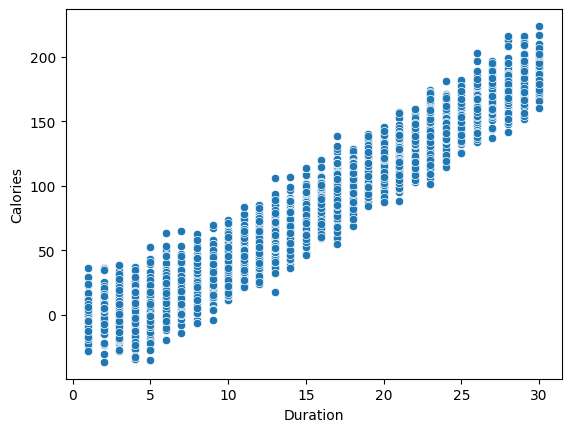

In [203]:
df = pd.DataFrame(test_data[:, 4], columns=["Duration"])
df["Calories"] = pd.DataFrame(y_pred)
sns.scatterplot(df, x="Duration", y="Calories")
